# Feature Selection by Filtering Methods

## Initialisation

In [1]:
import os

import numpy as np
import pandas as pd

path = os.getcwd()
# find the string 'project' in the path, return index
index_project = path.find('project')
# slice the path from the index of 'project' to the end
project_path = path[:index_project+7]
# set the working directory
os.chdir(project_path)
print(f'Project path set to: {os.getcwd()}')

Project path set to: c:\Github\ode-biomarker-project


In [2]:
# Bring in CCLE data
from PathLoader import PathLoader
from DataLink import DataLink
path_loader = PathLoader('data_config.env', 'current_user.env')
data_link = DataLink(path_loader, 'data_codes.csv')

In [3]:
# load in original ccle data
loading_code = 'generic-gdsc-1-FGFR_0939-LN_IC50-fgfr4_ccle_dynamic_features-true-Row'
# generic-gdsc-{number}-{drug_name}-{target_label}-{dataset_name}-{replace_index}-{row_index}
feature_data, label_data = data_link.get_data_using_code(loading_code)

In [4]:
from toolkit import *

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


## Analysis Chain

In [5]:
feature_size = feature_data.shape[1]
key_args = {'random_state': 42}

rf_selected, rf_score = rf_select(feature_data, label_data, feature_size, **key_args)

In [10]:
def build_dataframe(selected_indices, scores, feature_data): 
    # if selected_indices are not indices but labels, skip the label conversion step 
    if not isinstance(selected_indices[0], int) and not isinstance(selected_indices[0], np.int64):
        labels = selected_indices
    else:
        labels = feature_data.columns[selected_indices]
    df = pd.DataFrame({'Selected': selected_indices, 'Scores': scores}, index=labels)
    sorted_df = df.sort_values(by='Scores', ascending=False)
    return sorted_df

In [23]:
rf_select_df = build_dataframe(rf_selected, rf_score, feature_data)

In [24]:
rf_select_df 

,Selected,Scores
pFRS2_tfc,72,0.032156
aCbl_tfc,232,0.031272
aPDK1_ttsv,97,0.023051
aGAB2_tfc,192,0.021686
pMEK_tsv,168,0.017384
...,...,...
aGAB2_tmin,195,0.000000
aGAB2_init,199,0.000000
aCbl_tmax,233,0.000000
aGAB2_min,196,0.000000


In [25]:
relieff_selected, relieff_score = relieff_select(feature_data, label_data, feature_size)

In [26]:
relieff_select_df = build_dataframe(relieff_selected, relieff_score, feature_data)
relieff_select_df

,Selected,Scores
FOXO_max,244,33.631208
FOXO_median,241,33.449453
FOXO_init,249,21.131582
FOXO_auc,240,19.946035
aGAB1_tfc,182,15.547287
...,...,...
pFGFR4_tsv,28,-21.548295
pFGFR4_median,21,-24.586229
pFGFR4_auc,20,-24.942593
pFGFR4_min,26,-26.712830


In [27]:
f_selected, f_score = f_regression_select(feature_data, label_data, feature_size)
f_df = build_dataframe(f_selected, f_score, feature_data)
f_df

invalid value encountered in sqrt


,Selected,Scores
amTORC2_tfc,amTORC2_tfc,8.205615
aGAB1_max,aGAB1_max,7.572399
aGAB1_tsv,aGAB1_tsv,7.566082
aShp2_max,aShp2_max,7.496536
aShp2_tsv,aShp2_tsv,7.493012
...,...,...
PTP_tmax,PTP_tmax,0.000000
aCbl_tmin,aCbl_tmin,0.000000
aRaf_tmax,aRaf_tmax,0.000000
pMEK_tmax,pMEK_tmax,0.000000


In [12]:
pearson_kwargs = {'return_all': True}
pearson_selected, pearson_score, pearson_pvals = pearson_corr_select(feature_data, label_data, feature_size, **pearson_kwargs)
pearson_df = build_dataframe(pearson_selected, pearson_score, feature_data)
pearson_df

An input array is constant; the correlation coefficient is not defined.


,Selected,Scores
aGAB1_max,aGAB1_max,0.106266
aGAB1_tsv,aGAB1_tsv,0.106222
aShp2_max,aShp2_max,0.105738
aShp2_tsv,aShp2_tsv,0.105714
aShp2_auc,aShp2_auc,0.105639
...,...,...
PTP_tmax,PTP_tmax,NaN
PTP_tmin,PTP_tmin,NaN
aCbl_tmax,aCbl_tmax,NaN
aCbl_tmin,aCbl_tmin,NaN


In [13]:
mutual_selected, mutual_score = mutual_information_select(feature_data, label_data, feature_size)
mutual_df = build_dataframe(mutual_selected, mutual_score, feature_data)
mutual_df

,Selected,Scores
FOXO_min,FOXO_min,0.098550
FOXO_tsv,FOXO_tsv,0.096417
FOXO_init,FOXO_init,0.070657
FOXO_auc,FOXO_auc,0.070053
aShp2_tfc,aShp2_tfc,0.069996
...,...,...
pERK_tfc,pERK_tfc,0.000000
aPI3K_max,aPI3K_max,0.000000
pMEK_ttsv,pMEK_ttsv,0.000000
aPI3K_init,aPI3K_init,0.000000


there are two options to ensemble the results of multiple different feature selection results 
1. To propose a universal k-cutoff rank number for all feature selection methods and then union the features 
    e.g. Gather FS Method 1's top 100 features and Gather FS Method 2's top 100 features and union them 
2. To ensemble the rank value of each feature from each method first, and then limit the number of features either using a k-cutoff rank number, or a k-cutoff threshold for the ensemble score. 

## Universal K-Cutoff Rank Method

In [62]:
k = 50 

def ensemble_k_rank_select(k: int, selection_methods: list, method_kwargs: list, feature_data, label_data):
    all_dfs = []
    assert len(selection_methods) == len(method_kwargs), 'Number of methods and method_kwargs must be equal'
    for idx, method in enumerate(selection_methods):
        selected, score = method(feature_data, label_data, feature_size, **method_kwargs[idx])
        df = build_dataframe(selected, score, feature_data)
        all_dfs.append(df)
    
    all_labels = union_df_labels(k,all_dfs)
    return all_labels

def union_df_labels(k, df_list):
    all_labels = []
    for df in df_list:
        k_best_labels = df.index.tolist()[:k]
        all_labels.extend(k_best_labels)
    
    all_labels = list(set(all_labels))
    return all_labels

In [75]:
# select_methods = [rf_select, relieff_select, f_regression_select, pearson_corr_select, mutual_information_select]
# method_kwargs = [{'random_state': 42}, {}, {}, {}, {}]
# ensemble_feature_list = ensemble_k_rank_select(k, select_methods, method_kwargs, feature_data, label_data)

df_list = [rf_select_df, relieff_select_df, f_df, pearson_df, mutual_df]
ensemble_labels = union_df_labels(k,df_list)
ensemble_labels

['aGAB1_tmin',
 'aShp2_tsv',
 'pFGFR4_median',
 'FOXO_tmax',
 'aPI3K_max',
 'pIGFR_tmin',
 'aPDK1_tmin',
 'aShp2_init',
 'pS6K_max',
 'FOXO_ttsv',
 'amTORC2_tmax',
 'PTP_auc',
 'aCbl_auc',
 'aGrb2_median',
 'aRas_ttsv',
 'PTP_min',
 'aGAB1_ttsv',
 'PTP_max',
 'aSos_tsv',
 'pFRS2_max',
 'amTORC2_tmin',
 'aRaf_auc',
 'aGAB1_auc',
 'aGrb2_init',
 'aSos_auc',
 'aPDK1_tsv',
 'aGAB2_min',
 'aCbl_tmin',
 'pAkt_init',
 'amTORC2_init',
 'pERBB_tfc',
 'FOXO_tsv',
 'pIGFR_init',
 'pIRS_tfc',
 'pFRS2_tsv',
 'aGrb2_ttsv',
 'amTORC1_tsv',
 'pIGFR_min',
 'pIGFR_tfc',
 'pAkt_tsv',
 'aCbl_init',
 'pS6K_auc',
 'aRas_median',
 'PIP3_median',
 'pFRS2_min',
 'pS6K_ttsv',
 'aCbl_ttsv',
 'PIP3_tsv',
 'pERK_tmin',
 'pIGFR_auc',
 'aCbl_tfc',
 'aRaf_max',
 'pMEK_tmax',
 'pERBB_auc',
 'pAkt_min',
 'aRaf_tmin',
 'pFGFR4_tmin',
 'PIP3_ttsv',
 'amTORC2_ttsv',
 'amTORC2_max',
 'pMEK_max',
 'pMEK_tfc',
 'pERBB_init',
 'pMEK_init',
 'pMEK_tmin',
 'aCbl_median',
 'pFRS2_tmin',
 'pFRS2_tfc',
 'amTORC1_tmax',
 'aGAB2_med

In [76]:
len(ensemble_labels)

260

### K-Curve Analysis

based on a k ranging from 0 to n, we can visualise a line plot to the number of ensemble features selected vs the k value

if there is zero overlap, we can expect ensemble features's size to always be k * no. methods 
However, if the overlap is strong, ensemble's feature size should approach k



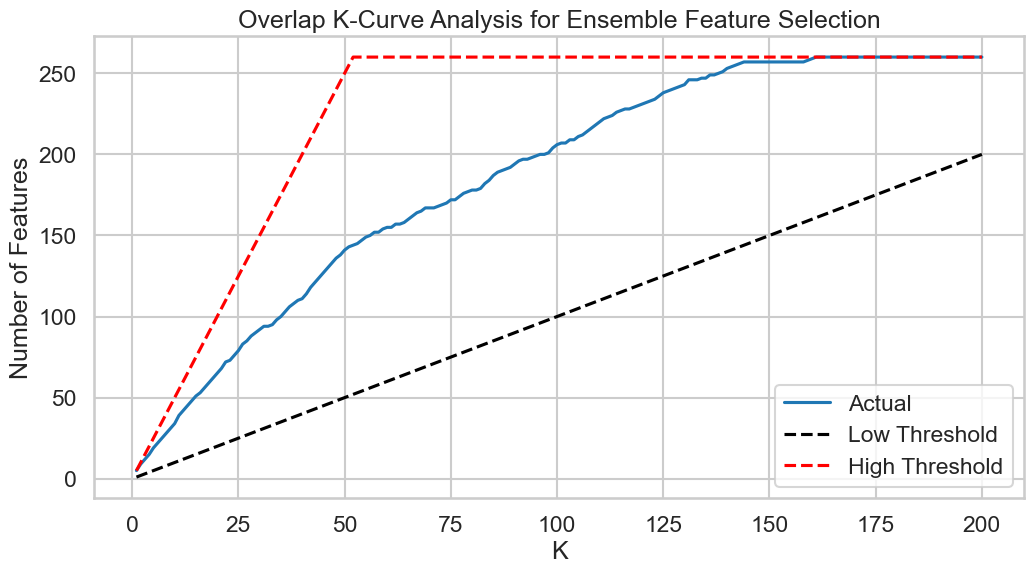

In [83]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context('talk')
sns.set_style('whitegrid')

max_k = 200
df_list = [rf_select_df, relieff_select_df, f_df, pearson_df, mutual_df]
ensemble_features_length_list = []
k_list = list(range(1, max_k+1))
for k in k_list:
    ensemble_labels = union_df_labels(k,df_list)
    ensemble_features_length_list.append(len(ensemble_labels))


# set plot size 
plt.figure(figsize=(12, 6))
plt.plot(k_list, ensemble_features_length_list, label='Actual')
plt.plot(k_list, k_list, linestyle='--', color='black', label='Low Threshold')
plt.plot(k_list, [k*len(df_list) if k*len(df_list) <= feature_size else feature_size for k in k_list], linestyle='--', color='red', label='High Threshold')
plt.xlabel('K')
plt.ylabel('Number of Features')
plt.title('Overlap K-Curve Analysis for Ensemble Feature Selection')
plt.legend()
plt.show()



## Sungyoung's statistical method 

By generating imputed samples which has shuffled targets. 

In [14]:
random_seeds = list(range(1, 1000))    
shuffled_label_data = [label_data.sample(frac=1, random_state=seed) for seed in random_seeds]

In [8]:
feature_size = feature_data.shape[1]
key_args = {'random_state': 42}

In [11]:
f_selected, f_score = f_regression_select(feature_data, shuffled_label_data[0], feature_size)
f_df = build_dataframe(f_selected, f_score, feature_data)
f_df

invalid value encountered in sqrt


,Selected,Scores
pFGFR4_median,pFGFR4_median,4.805171
pFGFR4_auc,pFGFR4_auc,4.738471
pFGFR4_tsv,pFGFR4_tsv,4.427173
pFGFR4_max,pFGFR4_max,4.427153
aCbl_tsv,aCbl_tsv,4.252007
...,...,...
aGAB2_ttsv,aGAB2_ttsv,0.000000
pMEK_tmax,pMEK_tmax,0.000000
SPRY2_tmin,SPRY2_tmin,0.000000
aCbl_tmax,aCbl_tmax,0.000000


invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value 

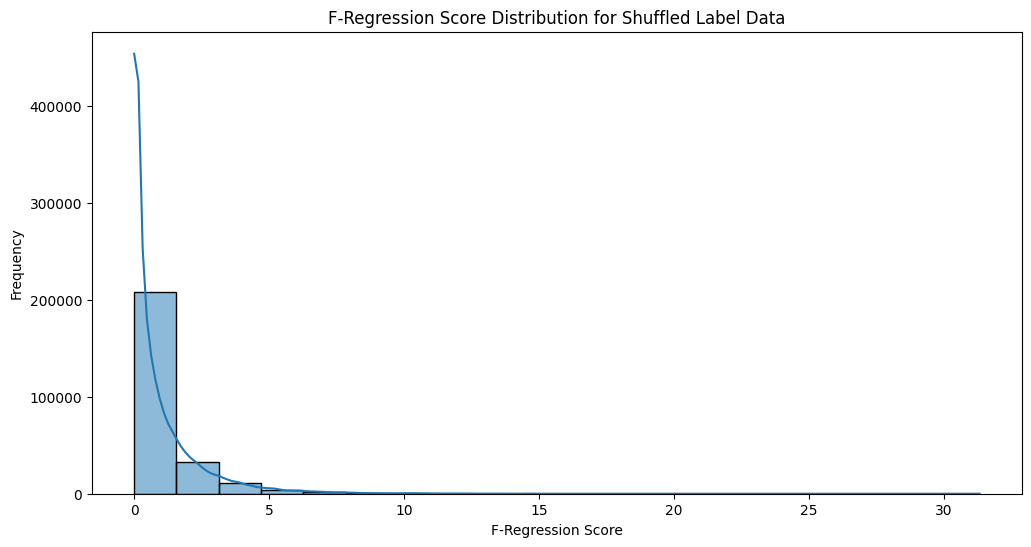

In [23]:
# do it for all shuffled label data, join the scores and plot histogram distribution of scores 

import matplotlib.pyplot as plt
import seaborn as sns

method = f_regression_select
method_kwargs = {}

def get_shuffled_scores(shuffled_label_data, feature_data, selection_method, method_kwargs):
    all_scores = []
    for label_data in shuffled_label_data:
        selected, score = selection_method(feature_data, label_data, feature_size, **method_kwargs)
        all_scores.extend(score)
    return all_scores

all_scores = get_shuffled_scores(shuffled_label_data, feature_data, method, method_kwargs)

# set plot size
plt.figure(figsize=(12, 6))
sns.histplot(all_scores, bins=20, kde=True)
plt.xlabel('F-Regression Score')
plt.ylabel('Frequency')
plt.title('F-Regression Score Distribution for Shuffled Label Data')
plt.show()

In [24]:
# take the top 5% of scores as the threshold for feature selection
# remove nan first
all_scores = [score for score in all_scores if not np.isnan(score)]
threshold = np.percentile(all_scores, 95)
threshold

3.7952337708838777

An input array is constant; the correlation coefficient is not defined.


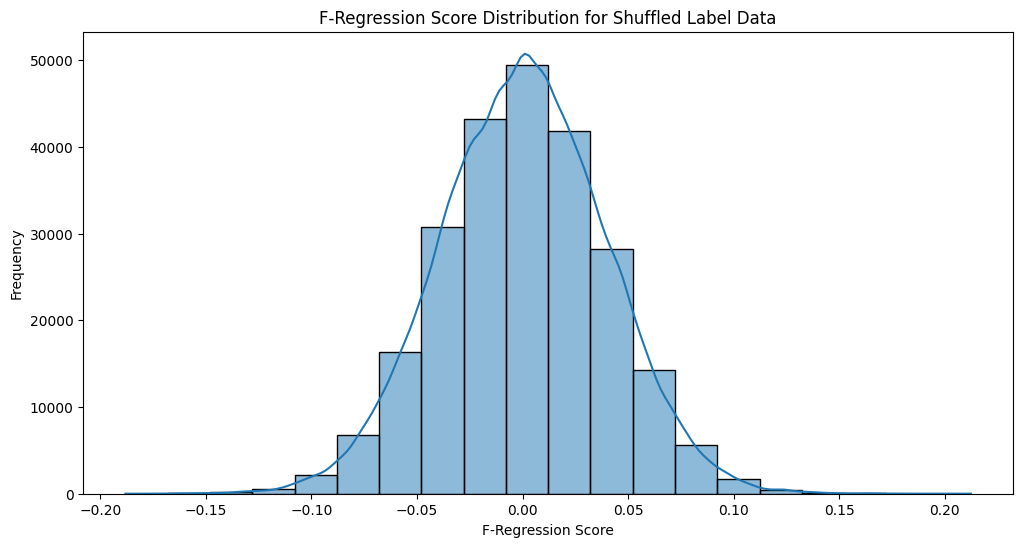

In [25]:
method = pearson_corr_select
method_kwargs = {'return_all': False}
all_scores = get_shuffled_scores(shuffled_label_data, feature_data, method, method_kwargs)

all_scores = [score for score in all_scores if not np.isnan(score)]
threshold = np.percentile(all_scores, 95)

# set plot size
plt.figure(figsize=(12, 6))
sns.histplot(all_scores, bins=20, kde=True)
plt.xlabel('F-Regression Score')
plt.ylabel('Frequency')
plt.title('F-Regression Score Distribution for Shuffled Label Data')
plt.show()